In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from myutils import (
    get_rolling_kelly, process_data, get_historical_var, calculate_daily_rf, get_cumulative_returns
)

In [70]:
# 데이터 겟
sp500 = pd.read_csv('SP500_mine.csv')
sp500 = process_data(sp500)

kospi = pd.read_csv('KOSPI200.csv')
kospi = process_data(kospi)

In [71]:
# rf 추가
rf = pd.read_csv('rf_data.csv')
rf.columns = ['Date', 'rf']
rf = calculate_daily_rf(rf, 250)
sp500 = sp500.join(rf)
kospi = kospi.join(rf)
# sp500[pd.isna(sp500['rf'])]

# rf 없는 지점은 그 바로 전날 값으로 채워넣음
kospi['rf'] = kospi['rf'].ffill()
sp500['rf'] = sp500['rf'].ffill()

In [72]:
# VaR 계산
kospi_var = get_historical_var(kospi, 400, 0.05)
sp500_var = get_historical_var(sp500, 400, 0.05)

In [56]:
# Kelly 계산
rolling_kelly = get_rolling_kelly(kospi_var)
kospi_var['kelly'] = rolling_kelly

rolling_kelly = get_rolling_kelly(sp500_var)
sp500_var['kelly'] = rolling_kelly

In [57]:
# 정해둔 시점에 대한 값만 겟
index_location = sp500_var.index.get_loc('01/08/2009')
sp500_target = sp500_var.iloc[index_location+1:]

In [58]:
sp500_target.isna().sum()

Price       0
Open        0
High        0
Low         0
Change %    0
Change      0
rf          0
VaR         0
kelly       0
dtype: int64

### Kelly 지수 관련 시각화

In [59]:
sp500_target['kelly'].describe()

count    3736.000000
mean        4.960530
std         5.430819
min        -3.384364
25%         1.206524
50%         3.063524
75%         8.307597
max        34.850058
Name: kelly, dtype: float64

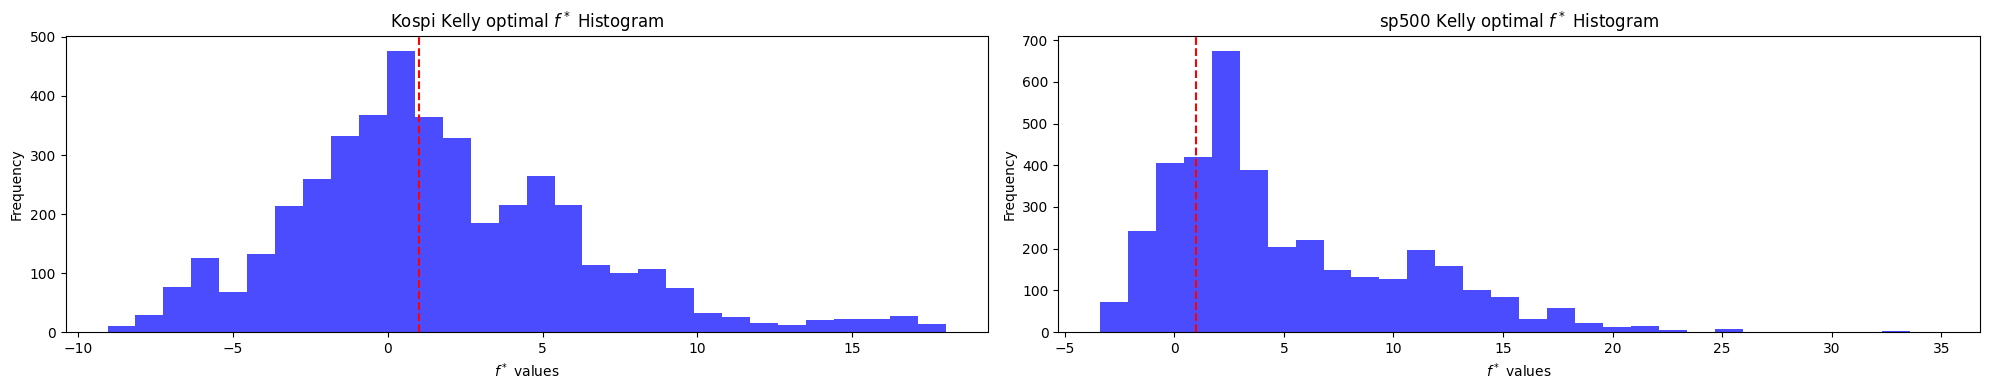

In [60]:
# 서브플롯 설정
fig, ax = plt.subplots(ncols=2, figsize=(20, 4))

# Kospi Kelly optimal f* 히스토그램
ax[0].hist(kospi_var['kelly'], bins=30, color='blue', alpha=0.7)
ax[0].set_xlabel('$f^*$ values')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Kospi Kelly optimal $f^*$ Histogram')
ax[0].axvline(x=1, color='red', linestyle='--')

# Kospi Kelly optimal f* 히스토그램
ax[1].hist(sp500_target['kelly'], bins=30, color='blue', alpha=0.7)
ax[1].set_xlabel('$f^*$ values')
ax[1].set_ylabel('Frequency')
ax[1].set_title('sp500 Kelly optimal $f^*$ Histogram')
ax[1].axvline(x=1, color='red', linestyle='--')

plt.tight_layout()
plt.show()

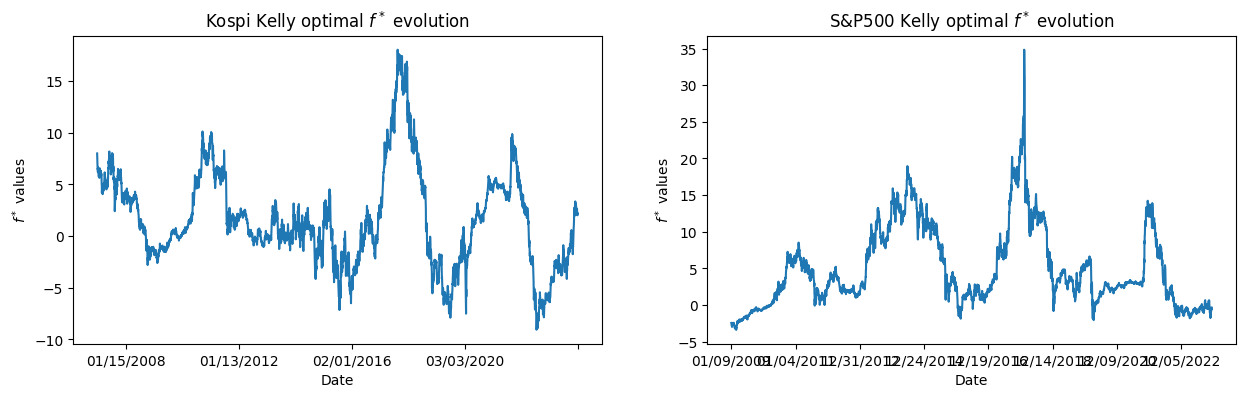

In [61]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 4))

kospi_var['kelly'].plot(ax=ax[0])
ax[0].set_ylabel('$f^*$ values');
ax[0].set_title('Kospi Kelly optimal $f^*$ evolution');

sp500_target['kelly'].plot(ax=ax[1])
ax[1].set_ylabel('$f^*$ values');
ax[1].set_title('S&P500 Kelly optimal $f^*$ evolution');

### 다시 캘리

In [62]:
# sp500_target['kelly_ratio'] = sp500_target['kelly'] / 100
sp500_target['kelly_ratio'] = sp500_target['kelly']

/var/folders/yz/s1q6x0ws0mq8fpv7l4vlz9_c0000gn/T/ipykernel_48733/3592935947.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500_target['kelly_ratio'] = sp500_target['kelly']


In [63]:
sp500_zero_kelly = sp500_target.copy()
sp500_zero_kelly['kelly_ratio'] = sp500_zero_kelly['kelly_ratio'].apply(lambda x: x if x>0 else 0)

In [64]:
def update_kelly(row):
    if row['VaR'] < row['Change']:
        # return row['VaR']
        return 0
    else:
        return row['kelly_ratio']
    
sp500_result_var_kelly = sp500_target.copy()
# apply 함수를 사용하여 kelly_ratio 업데이트
sp500_result_var_kelly['kelly_ratio'] = sp500_result_var_kelly.apply(lambda row: update_kelly(row), axis=1)

In [65]:
rebalancing = 10
sp500_result = get_cumulative_returns(sp500_target, rebalancing)
sp500_result_zero_kelly = get_cumulative_returns(sp500_zero_kelly, rebalancing)
sp500_result_var_kelly = get_cumulative_returns(sp500_result_var_kelly, rebalancing)

/Users/kimjihyo/Documents/GitHub/The-Kelly-Criterion/myutils.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'portfolio'] = portfolio
/Users/kimjihyo/Documents/GitHub/The-Kelly-Criterion/myutils.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'equity'] = equity
/Users/kimjihyo/Documents/GitHub/The-Kelly-Criterion/myutils.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

In [66]:
# for index, row in sp500_result.iterrows():
#     if row['Change'] < row['VaR']:
#         print(row['Change'], row['VaR'])
#         sp500_result.at[index, 'kelly_ratio'] = 0

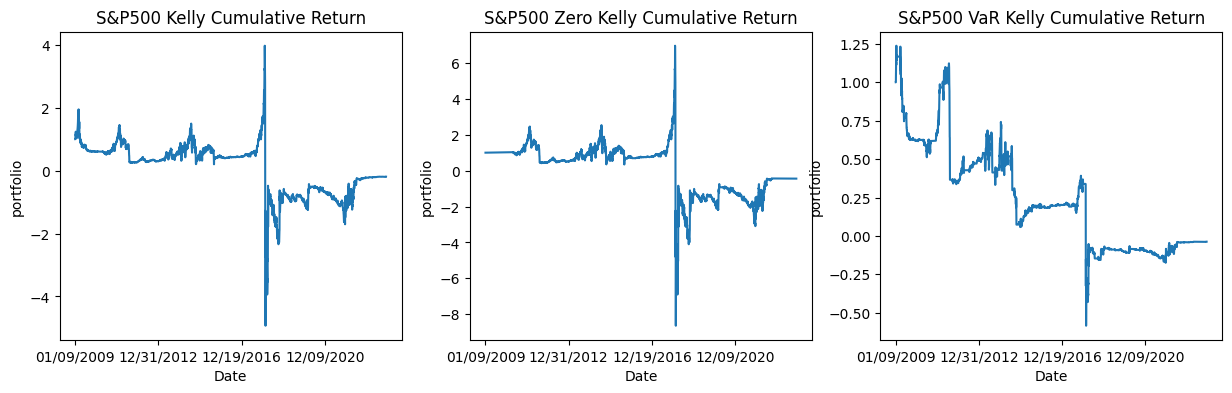

In [67]:
fig, ax = plt.subplots(ncols=3, figsize=(15, 4))

sp500_result['portfolio'].plot(ax=ax[0])
ax[0].set_ylabel('portfolio');
ax[0].set_title('S&P500 Kelly Cumulative Return');

sp500_result_zero_kelly['portfolio'].plot(ax=ax[1])
ax[1].set_ylabel('portfolio');
ax[1].set_title('S&P500 Zero Kelly Cumulative Return');

sp500_result_var_kelly['portfolio'].plot(ax=ax[2])
ax[2].set_ylabel('portfolio');
ax[2].set_title('S&P500 VaR Kelly Cumulative Return');